<a href="https://www.kaggle.com/code/jaytatiya/submissions-nbme-csv?scriptVersionId=92054792" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd 
import numpy as np
import plotly.express as px # visualisations and graphs
import os
import spacy.displacy
import seaborn as sns
import json
import warnings
from IPython.core.display import display, HTML

In [2]:
DATA_ROOT = os.path.join(
    '..', 'input', 'nbme-score-clinical-patient-notes')

In [3]:
features = pd.read_csv("/kaggle/input/nbme-score-clinical-patient-notes/features.csv")
patient_notes = pd.read_csv("/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv")
train = pd.read_csv("/kaggle/input/nbme-score-clinical-patient-notes/train.csv") 
test = pd.read_csv("/kaggle/input/nbme-score-clinical-patient-notes/test.csv")
submission =pd.read_csv("/kaggle/input/nbme-score-clinical-patient-notes/sample_submission.csv")

## Features

In [4]:
features.head() 

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [5]:
features.tail()

,feature_num,case_num,feature_text
138,912,9,Family-history-of-migraines
139,913,9,Female
140,914,9,Photophobia
141,915,9,No-known-illness-contacts
142,916,9,Subjective-fever


In [6]:
print(f'Shape of features:{features.shape}, \n'
      f'With unique num of features: {features.feature_num.nunique()} \n'
      f'num of any missed cell in the df: {features.isna().sum().sum()}')

Shape of features:(143, 3), 
With unique num of features: 143 
num of any missed cell in the df: 0


## Notes

In [7]:
patient_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [8]:
patient_notes.tail()

,pn_num,case_num,pn_history
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...
42144,95333,9,Stephanie madden is a 20 year old woman compla...
42145,95334,9,patient is a 20 yo F who presents with a heada...


In [9]:
yo = patient_notes[patient_notes['pn_history'].str.contains('yo')].shape[0]
yo_dots = patient_notes[patient_notes['pn_history'].str.contains('y.o.')].shape[0]
yo_fulls = patient_notes[patient_notes['pn_history'].str.contains('year-old')].shape[0] + \
patient_notes[patient_notes['pn_history'].str.contains('years old')].shape[0] + \
patient_notes[patient_notes['pn_history'].str.contains('years-old')].shape[0] + \
patient_notes[patient_notes['pn_history'].str.contains('year old')].shape[0]

print(f'yo: {yo} \ny.o.: {yo_dots} \nyear old: {yo_fulls}')

yo: 22247 
y.o.: 19879 
year old: 9469


In [10]:
print(f'Shape of patient_notes:{patient_notes.shape}, \n'
      f'With unique num of patient notes: {patient_notes.pn_num.nunique()} \n'
      f'num of any missed cell in the df: {patient_notes.isna().sum().sum()}')

Shape of patient_notes:(42146, 3), 
With unique num of patient notes: 42146 
num of any missed cell in the df: 0


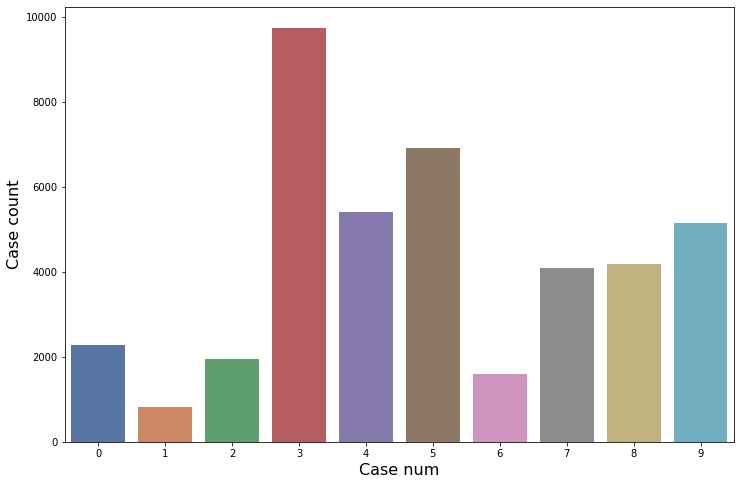

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
df_count = patient_notes.groupby('case_num').count()

f, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=df_count, x=df_count.index, y=df_count['pn_num'], palette=sns.color_palette("deep", 10))
plt.xlabel('Case num', fontsize=16)
plt.ylabel('Case count', fontsize=16)
plt.show()

In [12]:
submission.head(4)

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN


In [13]:
train.head(4)

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"


In [14]:
print("Checking Null's",train.isnull().sum())

Checking Null's id             0
case_num       0
pn_num         0
feature_num    0
annotation     0
location       0
dtype: int64


In [15]:
train.dtypes

id             object
case_num        int64
pn_num          int64
feature_num     int64
annotation     object
location       object
dtype: object

In [16]:
test.head(4)

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3


In [17]:
print("Checking Null's",test.isnull().sum())

Checking Null's id             0
case_num       0
pn_num         0
feature_num    0
dtype: int64


In [18]:
test.dtypes

id             object
case_num        int64
pn_num          int64
feature_num     int64
dtype: object

## Merge the datasets

## So, (annotation, location) is target what we should predict well


In [19]:
test = test.merge(features, on=['feature_num', 'case_num'], how='left')
test = test.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
display(test.head())

,id,case_num,pn_num,feature_num,feature_text,pn_history
0,00016_000,0,16,0,Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...
1,00016_001,0,16,1,Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...
2,00016_002,0,16,2,Chest-pressure,HPI: 17yo M presents with palpitations. Patien...
3,00016_003,0,16,3,Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...
4,00016_004,0,16,4,Lightheaded,HPI: 17yo M presents with palpitations. Patien...


In [20]:
df = train.append(features)
df

,id,case_num,pn_num,feature_num,annotation,location,feature_text
0,00016_000,0,16.0,0,['dad with recent heart attcak'],['696 724'],NaN
1,00016_001,0,16.0,1,"['mom with ""thyroid disease']",['668 693'],NaN
2,00016_002,0,16.0,2,['chest pressure'],['203 217'],NaN
3,00016_003,0,16.0,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",NaN
4,00016_004,0,16.0,4,['felt as if he were going to pass out'],['222 258'],NaN
...,...,...,...,...,...,...,...
138,NaN,9,NaN,912,NaN,NaN,Family-history-of-migraines
139,NaN,9,NaN,913,NaN,NaN,Female
140,NaN,9,NaN,914,NaN,NaN,Photophobia
141,NaN,9,NaN,915,NaN,NaN,No-known-illness-contacts


In [21]:
display(train.duplicated().sum())
train.tail()

0

,id,case_num,pn_num,feature_num,annotation,location
14295,95333_912,9,95333,912,[],[]
14296,95333_913,9,95333,913,[],[]
14297,95333_914,9,95333,914,['photobia'],['274 282']
14298,95333_915,9,95333,915,['no sick contacts'],['421 437']
14299,95333_916,9,95333,916,['Subjective fever'],['314 330']


In [22]:
counts_of_notes = patient_notes.groupby("case_num").count()
ind = counts_of_notes.index
fig = px.bar(data_frame= counts_of_notes, y='pn_num', x=ind, text_auto='.2s',
            title="Count Distribution of Different Cases",
            labels={'case_num': 'Case Number', 'pn_num': 'Number of Patients'},
            width=1100, height=700,
            color ='pn_num',
            color_continuous_scale='aggrnyl'
            )
fig.update_layout(
    title_x=0.5,
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(0,10)),
        ticktext = ['Case Zero', 'Case One', 'Case Two', 'Case Three', 'Case Four', 'Case Five', 'Case Six', 'Case Seven', 'Case Eight', 'Case Nine']
    )
)

fig.show()

In [23]:
PATIENT_IDX = 74087
patient_df = train[train["pn_num"] == PATIENT_IDX]
patient_df


,id,case_num,pn_num,feature_num,annotation,location
10791,74087_700,7,74087,700,['female'],['27 33']
10792,74087_701,7,74087,701,[],[]
10793,74087_702,7,74087,702,"['only had 2 cycles in the past 5 months', 'he...","['130 168', '182 192', '218 240', '48 73']"
10794,74087_703,7,74087,703,['LMP was 2 months ago'],['97 117']
10795,74087_704,7,74087,704,['has not restarted contraception'],['641 672']
10796,74087_705,7,74087,705,[],[]
10797,74087_706,7,74087,706,['not been able to get pregnant'],['465 494']
10798,74087_707,7,74087,707,['35 yo'],['21 26']
10799,74087_708,7,74087,708,['6 months'],['87 95']


In [24]:
features[features['feature_num'] == 708]


,feature_num,case_num,feature_text
107,708,7,symptoms-for-6-months


In [25]:
def annotate_sample(note_num):
    note_num = int(note_num)
    warnings.filterwarnings('ignore')
    patient_df = train[train["pn_num"] == note_num].copy()
    patient_df = patient_df.merge(features[['feature_num', 'feature_text']], on='feature_num')
    # WK: location should be a list of str, which some ";" should be handled and turned to ","
    patient_df["location"] = patient_df["location"].str.replace("'", '"').str.replace(';', '","').apply(json.loads)  # WK: list of str,    annotation = patient_df["feature_text"]
    annotation = patient_df["feature_text"]
    ents = []
    for idx, row in patient_df.iterrows():
        spans = row['location']
        label = row['feature_text']
        for span in spans:
            start_loc = span.split()[0]
            end_loc = span.split()[1]
            ents.append({
                'start': int(start_loc),
                'end': int(end_loc),
                'label': label
            })
    doc = {
        'text': patient_notes[patient_notes["pn_num"] == note_num]["pn_history"].iloc[0],
        "ents": ents
    }
    p1 = sns.color_palette('hls', annotation.nunique(), desat=1).as_hex()
    p2 = sns.color_palette('hls', annotation.nunique(), desat=0.5).as_hex()
    colors = {k: f"linear-gradient(90deg, {c1}, {c2})" for k, c1, c2 in zip(annotation.unique(), p1, p2)}
    options = {"colors": colors}
    spacy.displacy.render(doc, style="ent", options=options, manual=True, jupyter=True)

In [26]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [27]:
case_numbers = list(map(str, patient_notes['case_num'].unique()))
case_num_selector = widgets.Dropdown(
    options=case_numbers,
    value=case_numbers[0],
    description='Case No:',
)

def update_note_selector():
    note_numbers = list(
        map(
            str, 
            train[train['case_num'] == int(case_num_selector.value)]['pn_num'].unique()))

    note_num_selector = widgets.Dropdown(
        options=note_numbers,
        value=note_numbers[0],
        description='Note No:',
    )

    return note_num_selector

note_num_selector = update_note_selector()

def on_case_no_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        note_numbers = list(
            map(
                str, 
                train[train['case_num'] == int(case_num_selector.value)]['pn_num'].unique()))
        note_num_selector.options=note_numbers
        note_num_selector.value=note_numbers[0]


        
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

        

        
case_num_selector.observe(on_case_no_change)
note_num_selector.observe(on_change)

display(case_num_selector)
display(note_num_selector)

Dropdown(description='Case No:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'), value='0')

Dropdown(description='Note No:', options=('16', '41', '46', '82', '100', '161', '188', '211', '224', '225', '2…

In [28]:
# Change the widget value above and re-run this cell to explore labels in the notes
annotate_sample(note_num_selector.value)

for the annotations I referred: https://www.kaggle.com/code/weicongkong/eda-handy-patient-notes-label-visualiser